In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, Select
from ipywidgets import interactive
import plotly.express as px
from ipywidgets import interact, Dropdown
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

from pylab import mpl 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 为了显示负号正常

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 加载数据
data = pd.read_csv("E:\\竞赛\\服创赛-A08\\data\\process_data.csv")
data = data.drop('个人编码',axis=1)
data.info()


# 计算斯皮尔曼等级相关系数
spearman_corr = data.corr(method='spearman')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 81 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   一天去两家医院的天数         16000 non-null  int64  
 1   就诊的月数              16000 non-null  int64  
 2   月就诊天数_MAX          16000 non-null  int64  
 3   月就诊天数_AVG          16000 non-null  float64
 4   月就诊医院数_MAX         16000 non-null  int64  
 5   月就诊医院数_AVG         16000 non-null  float64
 6   就诊次数_SUM           16000 non-null  int64  
 7   月就诊次数_MAX          16000 non-null  int64  
 8   月就诊次数_AVG          16000 non-null  float64
 9   月统筹金额_MAX          16000 non-null  float64
 10  月统筹金额_AVG          16000 non-null  float64
 11  月药品金额_MAX          16000 non-null  float64
 12  月药品金额_AVG          16000 non-null  float64
 13  医院_就诊天数_MAX        16000 non-null  int64  
 14  医院_就诊天数_AVG        16000 non-null  float64
 15  医院_统筹金_MAX         16000 non-null  float64
 16  医院_统筹金_AVG         160

## 原始数据散点图

In [3]:
# 定义一个函数来绘制散点图
def interactive_scatter(x, y, z=None):
    if z is None:
        fig = px.scatter(data, x=x, y=y, color='RES')
    else:
        # fig = px.scatter_3d(data, x=x, y=y, z=z, color='RES')
        fig = px.scatter_3d(data, x=x, y=y, z=z, color='RES', width=1000, height=600)
    
    fig.show()

    # 检查所选特征间的相关性
    if z is None:
        corr_value = spearman_corr.loc[x, y]
        if abs(corr_value) > 0.85:
            print(f"注意：所选特征 '{x}' 和 '{y}' 之间的相关性很高 (相关系数: {corr_value:.2f}).")
    else:
        corr_xy = spearman_corr.loc[x, y]
        corr_xz = spearman_corr.loc[x, z]
        corr_yz = spearman_corr.loc[y, z]
        if abs(corr_xy) > 0.85:
            print(f"注意：特征 '{x}' 和 '{y}' 之间的相关性很高 (相关系数: {corr_xy:.2f}).")
        if abs(corr_xz) > 0.85:
            print(f"注意：特征 '{x}' 和 '{z}' 之间的相关性很高 (相关系数: {corr_xz:.2f}).")
        if abs(corr_yz) > 0.85:
            print(f"注意：特征 '{y}' 和 '{z}' 之间的相关性很高 (相关系数: {corr_yz:.2f}).")



# 创建下拉框
dropdown_x = Dropdown(options=data.columns, description='X轴')
dropdown_y = Dropdown(options=data.columns, description='Y轴')
dropdown_z = Dropdown(options=[None] + list(data.columns), description='Z轴', value=None)

In [4]:
# 使用交互式控件
interact(interactive_scatter, x=dropdown_x, y=dropdown_y, z=dropdown_z)

interactive(children=(Dropdown(description='X轴', options=('一天去两家医院的天数', '就诊的月数', '月就诊天数_MAX', '月就诊天数_AVG', '月就…

<function __main__.interactive_scatter(x, y, z=None)>

## PCA降维


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# 提取特征和目标变量 "RES
features = data.drop('RES', axis=1)
target = data['RES']

# 功能标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#应用 PCA 将维度减少到 3 个
pca = PCA(n_components=3)
components = pca.fit_transform(features_scaled)

# 为 3 个主成分创建数据帧
components_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3'])
components_df['RES'] = target

# 使用 plotly 绘制三维散点图
fig = px.scatter_3d(components_df, x='PC1', y='PC2', z='PC3', color='RES',
                    title="3D Scatter Plot of the Principal Components",
                    labels={'RES': 'Class'},width=800,height=800)
fig.show()


## 删除异常值之后PCA

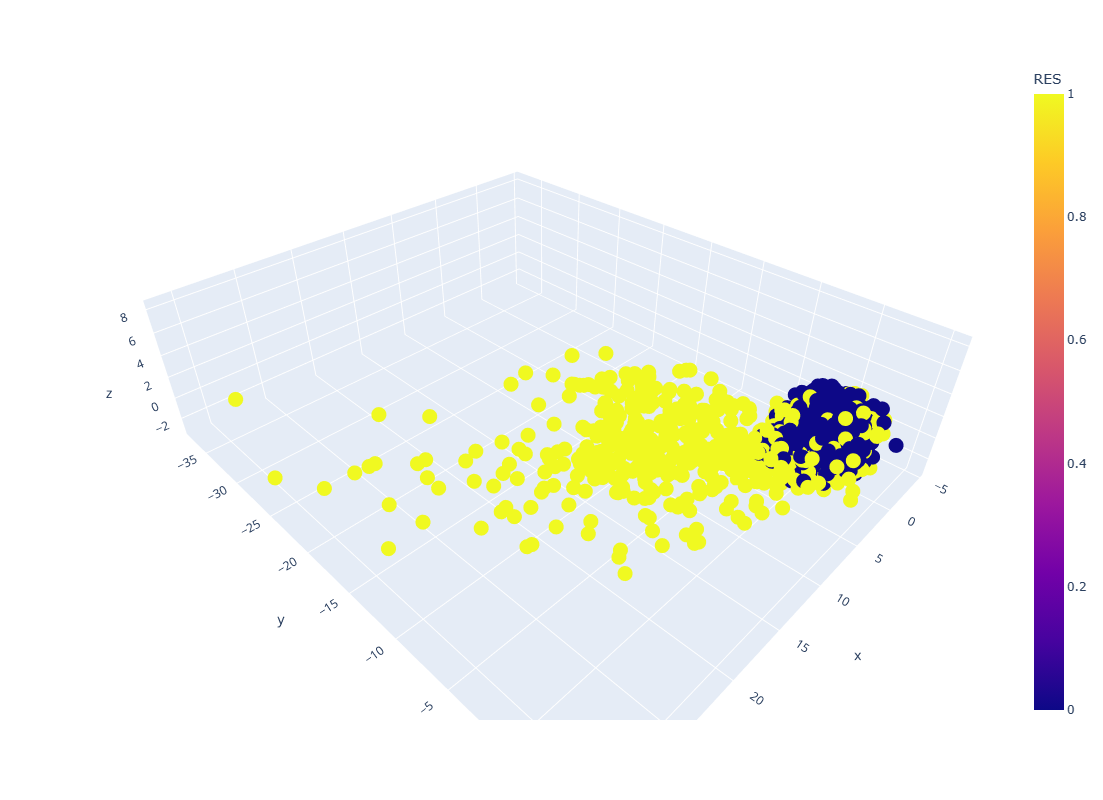

In [6]:
# 选择仅数值类型的列进行PCA
numeric_data = data.select_dtypes(include=[float, int])

# 标准化数据 - 对PCA很重要
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# 识别并移除类别0（RES = 0）中的异常值 - 使用四分位数方法
category_0_df = pd.DataFrame(scaled_data[data['RES'] == 0], columns=numeric_data.columns)

# 计算四分位数和IQR
Q1 = category_0_df.quantile(0.25)
Q3 = category_0_df.quantile(0.75)
IQR = Q3 - Q1

# 使用IQR识别异常值
outlier_rows_iqr = ((category_0_df < (Q1 - 1.5 * IQR)) | (category_0_df > (Q3 + 1.5 * IQR))).any(axis=1)
cleaned_category_0_data_iqr = category_0_df[~outlier_rows_iqr]

# 使用PCA将维度降至3
pca = PCA(n_components=3)
reduced_data_0_iqr = pca.fit_transform(cleaned_category_0_data_iqr)
reduced_data_1_iqr = pca.transform(scaled_data[data['RES'] == 1])

# 准备绘图数据
reduced_data_iqr = np.vstack((reduced_data_0_iqr, reduced_data_1_iqr))
res_labels_iqr = np.hstack((np.zeros(reduced_data_0_iqr.shape[0]), np.ones(reduced_data_1_iqr.shape[0])))

# 绘制3D散点图
fig = px.scatter_3d(
    x=reduced_data_iqr[:, 0], y=reduced_data_iqr[:, 1], z=reduced_data_iqr[:, 2], color=res_labels_iqr, labels={'color': 'RES'},
    width=800,height=800
)
fig.show()


## 特征数据区分度

### 多项式回归决策边界

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display

In [8]:
# 创建两个下拉框进行特征选择
feature_list = data.columns.drop(['RES'])  # 去除 '个人编码' 和 'RES'
dropdown_feature_1 = widgets.Dropdown(options=feature_list, description='Feature 1:')
dropdown_feature_2 = widgets.Dropdown(options=feature_list, description='Feature 2:')

# 创建一个滑动条用于选择多项式的阶数
degree_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Degree:')
# 多项式回归函数
def polynomial_regression(feature_1, feature_2, degree):
    # 选择的特征
    X = data[[feature_1, feature_2]].values
    y = data['RES'].values

    # 初始化标准化器
    scaler = StandardScaler()
    
    # 对原始特征进行标准化
    X_scaled = scaler.fit_transform(X)
    
    # 多项式特征转换
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X_scaled)
    
    # 训练模型
    model = LinearRegression(
            positive=True,
            # alpha=0.5,  # Regularization strength
            # l1_ratio=0.5,  # Weight between L1 and L2 (0 for L2, 1 for L1)
            # penalty='elasticnet',
    )
    model.fit(X_poly, y)

    # 创建网格以绘制决策边界
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_X = np.c_[xx.ravel(), yy.ravel()]
    grid_X_scaled = scaler.transform(grid_X)  # 应用相同的标准化
    grid_X_poly = poly.transform(grid_X_scaled)  # 应用相同的多项式特征转换
    grid_y = model.predict(grid_X_poly).reshape(xx.shape)

    # 绘制散点图
    fig = px.scatter(data, x=feature_1, y=feature_2, color='RES')

    # 绘制决策边界
    fig.add_trace(go.Contour(x=x_range, y=y_range, z=grid_y, showscale=False, line_width=0))

    fig.update_layout(title='Polynomial Regression Decision Boundary', 
                      xaxis_title=feature_1, 
                      yaxis_title=feature_2)
    fig.show()


# 交互式控件
interactive_plot = widgets.interactive(polynomial_regression, 
                                       feature_1=dropdown_feature_1, 
                                       feature_2=dropdown_feature_2,
                                       degree=degree_slider)


In [9]:
display(interactive_plot)

interactive(children=(Dropdown(description='Feature 1:', options=('一天去两家医院的天数', '就诊的月数', '月就诊天数_MAX', '月就诊天数_A…

### 训练集数据分布

In [12]:
X = data.drop('RES',axis=1)
y = data['RES']

# 使用索引进行切割
train_idx, test_idx = train_test_split(X.index, test_size=0.3, random_state=123)

# 根据索引获取切割后的 DataFrame
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]
train_data = pd.concat([X_train, y_train], axis=1)

# 定义一个函数来绘制散点图
def interactive_scatter(x, y, z=None):
    if z is None:
        fig = px.scatter(train_data, x=x, y=y, color='RES')
    else:
        # fig = px.scatter_3d(data, x=x, y=y, z=z, color='RES')
        fig = px.scatter_3d(train_data, x=x, y=y, z=z, color='RES', width=1000, height=600)
    
    fig.show()

    # 检查所选特征间的相关性
    if z is None:
        corr_value = spearman_corr.loc[x, y]
        if abs(corr_value) > 0.85:
            print(f"注意：所选特征 '{x}' 和 '{y}' 之间的相关性很高 (相关系数: {corr_value:.2f}).")
    else:
        corr_xy = spearman_corr.loc[x, y]
        corr_xz = spearman_corr.loc[x, z]
        corr_yz = spearman_corr.loc[y, z]
        if abs(corr_xy) > 0.85:
            print(f"注意：特征 '{x}' 和 '{y}' 之间的相关性很高 (相关系数: {corr_xy:.2f}).")
        if abs(corr_xz) > 0.85:
            print(f"注意：特征 '{x}' 和 '{z}' 之间的相关性很高 (相关系数: {corr_xz:.2f}).")
        if abs(corr_yz) > 0.85:
            print(f"注意：特征 '{y}' 和 '{z}' 之间的相关性很高 (相关系数: {corr_yz:.2f}).")



# 创建下拉框
dropdown_x = Dropdown(options=data.columns, description='X轴')
dropdown_y = Dropdown(options=data.columns, description='Y轴')
dropdown_z = Dropdown(options=[None] + list(data.columns), description='Z轴', value=None)


# 使用交互式控件
interact(interactive_scatter, x=dropdown_x, y=dropdown_y, z=dropdown_z)



interactive(children=(Dropdown(description='X轴', options=('一天去两家医院的天数', '就诊的月数', '月就诊天数_MAX', '月就诊天数_AVG', '月就…

<function __main__.interactive_scatter(x, y, z=None)>

## 测试集数据分布

In [13]:
from sklearn.model_selection import train_test_split

X = data.drop('RES',axis=1)
y = data['RES']

# 使用索引进行切割
train_idx, test_idx = train_test_split(X.index, test_size=0.3, random_state=123)

# 根据索引获取切割后的 DataFrame
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]
test_data = pd.concat([X_test, y_test], axis=1)

# 定义一个函数来绘制散点图
def interactive_scatter(x, y, z=None):
    if z is None:
        fig = px.scatter(test_data, x=x, y=y, color='RES')
    else:
        # fig = px.scatter_3d(data, x=x, y=y, z=z, color='RES')
        fig = px.scatter_3d(test_data, x=x, y=y, z=z, color='RES', width=1000, height=600)
    
    fig.show()

    # 检查所选特征间的相关性
    if z is None:
        corr_value = spearman_corr.loc[x, y]
        if abs(corr_value) > 0.85:
            print(f"注意：所选特征 '{x}' 和 '{y}' 之间的相关性很高 (相关系数: {corr_value:.2f}).")
    else:
        corr_xy = spearman_corr.loc[x, y]
        corr_xz = spearman_corr.loc[x, z]
        corr_yz = spearman_corr.loc[y, z]
        if abs(corr_xy) > 0.85:
            print(f"注意：特征 '{x}' 和 '{y}' 之间的相关性很高 (相关系数: {corr_xy:.2f}).")
        if abs(corr_xz) > 0.85:
            print(f"注意：特征 '{x}' 和 '{z}' 之间的相关性很高 (相关系数: {corr_xz:.2f}).")
        if abs(corr_yz) > 0.85:
            print(f"注意：特征 '{y}' 和 '{z}' 之间的相关性很高 (相关系数: {corr_yz:.2f}).")



# 创建下拉框
dropdown_x = Dropdown(options=data.columns, description='X轴')
dropdown_y = Dropdown(options=data.columns, description='Y轴')
dropdown_z = Dropdown(options=[None] + list(data.columns), description='Z轴', value=None)


# 使用交互式控件
interact(interactive_scatter, x=dropdown_x, y=dropdown_y, z=dropdown_z)

interactive(children=(Dropdown(description='X轴', options=('一天去两家医院的天数', '就诊的月数', '月就诊天数_MAX', '月就诊天数_AVG', '月就…

<function __main__.interactive_scatter(x, y, z=None)>